# General

https://github.com/obersteiner/sparseSpACE/blob/master/ipynb/Tutorial.ipynb

The spatially-adaptive-combi framework aims at providing a generalized interface for calculating the Combination Technique with spatial adaptive strategies.

Currently this is restricted to the calculation of an integral over a function $f$:

$$\int_{x \in D} f(x) dx$$

where $x$ is an d-dimensional vector and D is the d-dimensional Domain which is defined by the lower bound $a$ and the upper bound $b$. Usually one defines $D=[0,1]^d$ but other rectangular domains are also possible.

# Functions

Lets look at my own max of many multi variate gaussians.

x---------
So let's first look at the pre-defined functions that we can use in the framework. All implemented funcitons can be found in Functions.py and they typically offer the functionality to evaluate the function at a certain point and to return the analytic integral value for a specified domain. Furthermore plotting a function is already available directly in the framework. So let's try one of the functions namely $GenzCornerPeak$.
x---------


In [1]:
#allows any changes on external files to be loaded on code run.
%load_ext autoreload
%autoreload 2

debug tuple <class 'numpy.ndarray'>
debug tuple <class 'numpy.ndarray'>


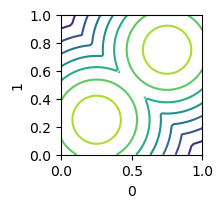

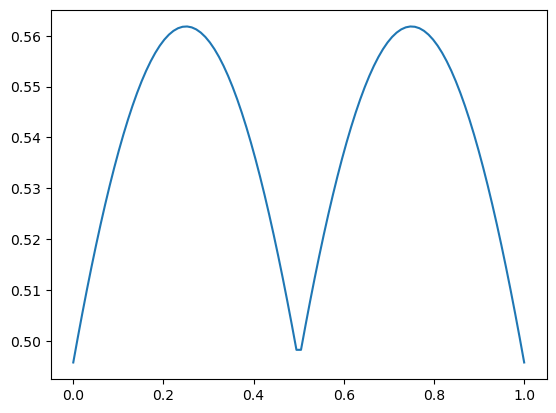

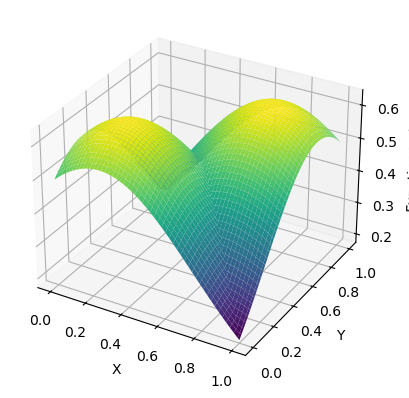

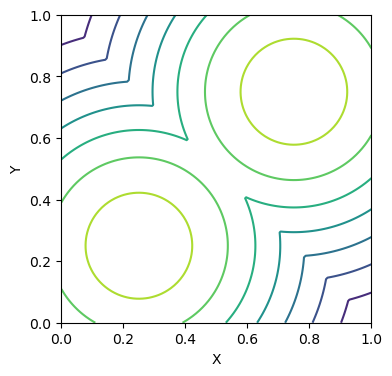

In [9]:
from sparseSpACE.Function import Function
import numpy as np
class function_wrap(Function):
    def __init__(self, function):
        # The function must be defined to be 0 outside the same boundaries that will be fed into SparseSpACE
        super().__init__()
        self.function = function

    def eval(self,X):
        return self.function(X)

import sys
import matplotlib.pyplot as plt
import os
sys.path.append(os.path.join(os.curdir,'..'))
from GENE_ML.gene_ml.test_functions.max_of_many_gaussians import MaxOfManyGaussians

num_dim = 2
confine = 0#0.5
mean_bounds = [(0+confine,1-confine) for i in range(num_dim)]
bounds = [(0,1) for i in range(num_dim)]
std_bounds=(0.1,0.5)
# std_bounds=(0.008,0.01)

num_gaussians = 2
mmg = MaxOfManyGaussians(num_dim, bounds)#num_dim, num_gaussians, bounds, mean_bounds, std_bounds, seed=10)
mmg.specify_gaussians(means=np.array([[0.25,0.25], [0.75,0.75]]), stds = np.array([[0.5,0.5],[0.5,0.5]]))
# mmg.plot_2d_gaussians(extra=0, grid_size=200, plot_bounds=[(0,1),(0,1)], style='contour')
# mmg.plot_2D_of_many(which2=(0,1), style='contour')
mmg.plot_matrix_contour()
if num_dim == 2: mmg.plot_2d_gaussians()
mmg_wraped = function_wrap(mmg.evaluate)




# %matplotlib inline
# import sparseSpACE

# from sparseSpACE.Function import *
# import numpy as np
# dim = 2
# coeffs = np.ones(dim)
# a = np.zeros(dim)
# b = np.ones(dim)
# f = GenzCornerPeak(coeffs=coeffs)
# f.plot(a, b)
# print("The function value at (0,0.5) is", f.eval((0,0.5)))
# print("The analytical integral value in the Domain [0,1]^d is", 
#       f.getAnalyticSolutionIntegral(np.zeros(dim), np.ones(dim)))

In [ ]:
# from sparseSpACE.Function import GenzCornerPeak
# #Change function
# num_dim = 2
# coeffs = np.ones(num_dim)
# mmg_wraped = GenzCornerPeak(coeffs=coeffs)


# How many points untill UQ-out distribution convergence?

## >2D

In [10]:
import numpy as np

# Example usage
bounds = [(0,1),(0,1)]
test_grid_size = 100  # Fine grid size
step_size = 5  # Coarser grid step size

# Generate the initial fine grid
x = [np.linspace(*b, test_grid_size) for b in bounds]
X = np.meshgrid(*x, indexing='ij')
pos_test = np.dstack(X)#np.vstack([Xi.ravel() for Xi in X]).T
Z_fine = mmg.evaluate(pos_test)

def create_coarse_grid(bounds, test_grid_size, step_size):
    # Reshape the grid to a higher-dimensional array
    grid_shape = [test_grid_size] * len(bounds)
    reshaped_grid = pos_test.reshape(grid_shape + [len(bounds)])

    # Select every nth point along each dimension
    slices = tuple(slice(None, None, step_size) for _ in bounds)
    coarse_grid = reshaped_grid[slices].reshape(-1, len(bounds))

    return coarse_grid



coarse_grid = create_coarse_grid(bounds, test_grid_size, step_size)

# Now you can evaluate the coarser grid
# Z_coarse = mmg.evaluate(coarse_grid)
X_coarse, Y_coarse = np.meshgrid(np.linspace(0, 1, test_grid_size // step_size), np.linspace(0, 1, test_grid_size // step_size))
Z_coarse = mmg.evaluate(coarse_grid).reshape(test_grid_size // step_size, test_grid_size // step_size)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(*X, Z_fine)
fig.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(coarse_grid[:0], coarse_grid[:1], Z_coarse)
fig.show()


ValueError: operands could not be broadcast together with shapes (100,100,2) (3,) 

In [ ]:
import os
import sys
sys.path.append('/home/djdaniel/GENE_UQ/GENE_ML')
from GENE_ML.gene_ml.uncertianty_quantification.montecarlo import Montecarlo, relative_entropy
from scipy.interpolate import griddata
# from GENE_ML.gene_ml.tools import plot_2D_of_many, plot_slices
from tqdm import tqdm
from GENE_ML.gene_ml.samplers.grid import Grid

num_dim = 4
num_gaussians = 5
bounds = [(0,1) for i in range(num_dim)]
mmg = MaxOfManyGaussians(num_dim, num_gaussians, bounds, std_bounds=(0.1,0.5), seed=42)

test_grid_size = 200

# for param, bound in zip(self.parameters,self.bounds):
#     x.append(np.linspace(*bound, self.num_samples_1D))
# X = np.meshgrid(*x)
# for param, Xi in zip(self.parameters,X):
#     samples[param] = Xi        
# samples_np = np.vstack([Xi.ravel() for Xi in X]).T


x = np.array([np.linspace(*b,test_grid_size) for b in bounds])
X = np.meshgrid(*x)
pos_test = np.vstack([Xi.ravel() for Xi in X]).T
Z_true = mmg.evaluate(pos_test)





grid_size_1d = np.arange(2,5)

rmse_grid = []

output_samples_previous = None
KL_div = []
num_bins = 100
mc_true = Montecarlo(mmg.evaluate)
print('TRUE')
mc_true.uniform_uq(num_samples=10**2, bounds=bounds, num_bins=num_bins)
print('TRUE')
for gs in tqdm(grid_size_1d, desc='Expanding Grid Size: '):
    print('Number of Grid Points:', gs**num_dim)
    x = np.array([np.linspace(*b,gs) for b in bounds])
    X = np.meshgrid(*x)
    pos_train = np.vstack([Xi.ravel() for Xi in X]).T
    z_train = mmg.evaluate(pos_train)
    Z_interpolate = griddata(pos_train, z_train, pos_test, method='linear')
    interpolate_fun = lambda pos: griddata(pos_train, z_train, pos, method='linear')
    mc_current = Montecarlo(interpolate_fun)
    mc_current.uniform_uq(num_samples=10**2, bounds=bounds)
    mc_current.plot_output_distribution(num_bins=100, overlay_dist_samples=mc_true.output_samples)
    # if type(output_samples_previous) == type(None):
    #     output_samples_previous = mc_current.output_samples
    # else:
    KL_div.append(relative_entropy(mc_current.output_samples, mc_true.output_samples, num_bins=num_bins))

    rmse_grid.append(np.sqrt(np.mean((Z_true - Z_interpolate)**2)))
    # plot_2D_of_many(function=interpolate_fun, bounds=bounds, nominals=[0.5,0.5],which2=[0,1], grid_size=200)
    # plot_slices(mmg.evaluate, interpolate_fun, bounds=bounds)



/tmp/ipykernel_123147/3352694142.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


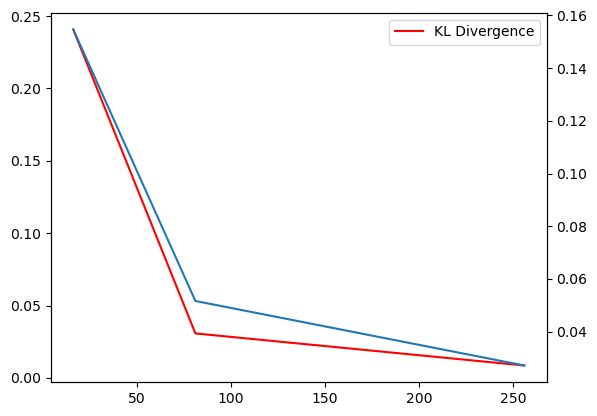

In [4]:
num_grid_points = grid_size_1d**num_dim
fig, ax = plt.subplots(1,1)
ax_t = ax.twinx()
ax.plot(num_grid_points,KL_div, color='red', label='KL Divergence')
ax_t.plot(num_grid_points, rmse_grid, label='Interpolator RMSE (right axis)')
ax.legend()
fig.show()

/tmp/ipykernel_89468/3352694142.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


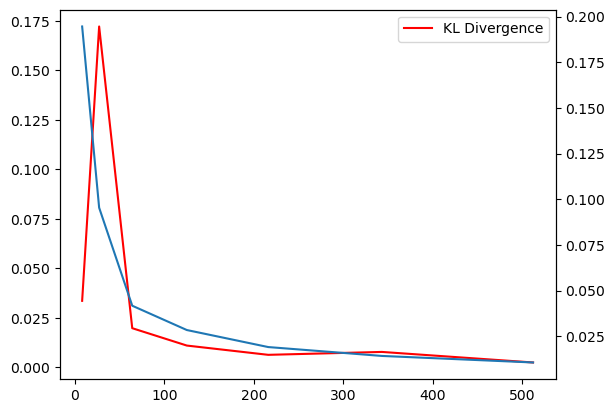

In [33]:
num_grid_points = grid_size_1d**num_dim
fig, ax = plt.subplots(1,1)
ax_t = ax.twinx()
ax.plot(num_grid_points,KL_div, color='red', label='KL Divergence')
ax_t.plot(num_grid_points, rmse_grid, label='Interpolator RMSE (right axis)')
ax.legend()
fig.show()

## Full Grid

TRUE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


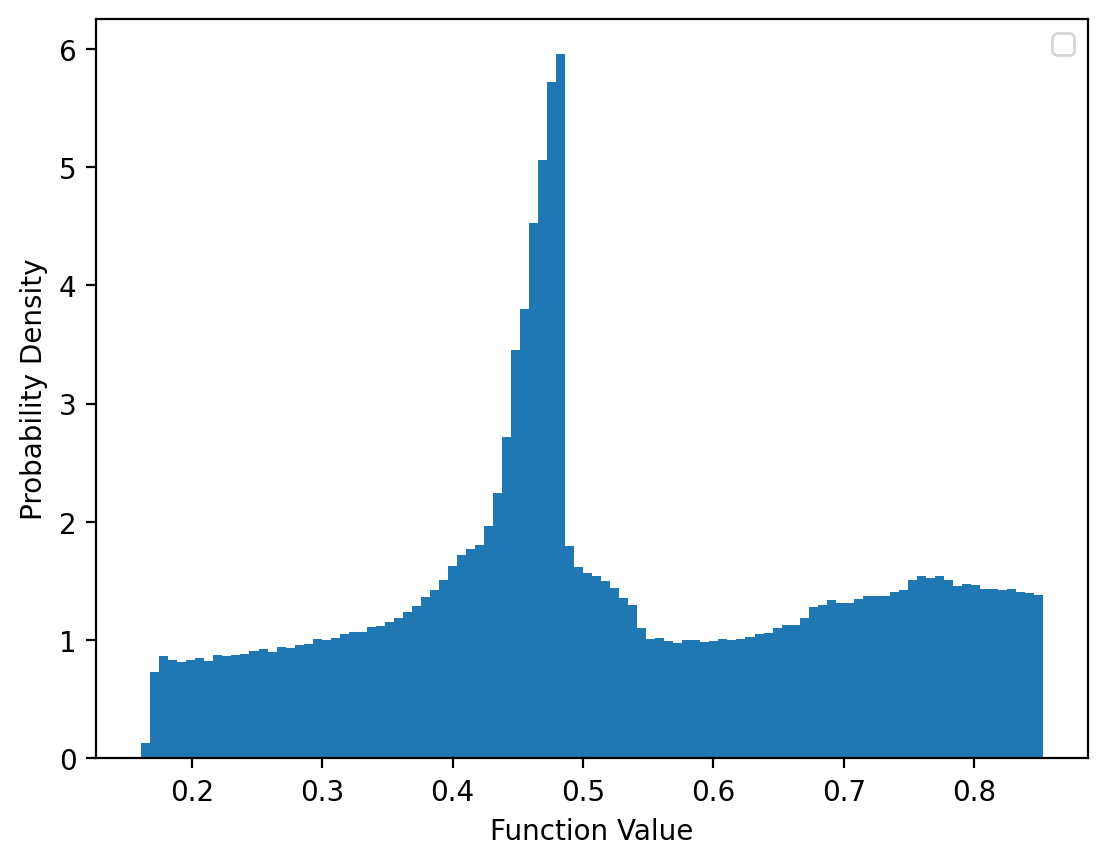

TRUE


Expanding Grid Size:   0%|          | 0/7 [00:00<?, ?it/s]

Number of Grid Points: 4


ValueError: operands could not be broadcast together with shapes (1,2) (3,) 

In [22]:
from GENE_ML.gene_ml.uncertianty_quantification.montecarlo import Montecarlo, relative_entropy
from scipy.interpolate import griddata
from GENE_ML.gene_ml.tools import plot_2D_of_many, plot_slices
from tqdm import tqdm

num_dim = 2
num_gaussians = 5
bounds = [(0,1) for i in range(num_dim)]
mmg = MaxOfManyGaussians(num_dim, num_gaussians, bounds, std_bounds=(0.1,0.5), seed=42)


grid_size_1d = np.arange(2,9)

test_grid_size = 500
x = np.linspace(0,1,test_grid_size)
y = np.linspace(0,1,test_grid_size)
X,Y = np.meshgrid(x,y)
pos_test = np.dstack((X, Y))
Z_true = mmg.evaluate(pos_test)
    
rmse_grid = []

output_samples_previous = None
KL_div = []
bounds = [(0,1),(0,1)]
num_bins = 100
mc_true = Montecarlo(mmg.evaluate)
print('TRUE')
mc_true.uniform_uq(num_samples=10**6, bounds=bounds, num_bins=num_bins)
print('TRUE')
for gs in tqdm(grid_size_1d, desc='Expanding Grid Size: '):
    print('Number of Grid Points:', gs**2)
    x = np.linspace(0,1,gs)
    y = np.linspace(0,1,gs)

    px, py, z_train = [], [], []
    for xi in x:
        for yi in y:
            px.append(xi)
            py.append(yi)
            z_train.append(mmg_wraped.eval((xi,yi)))

    Z_interpolate = griddata((px,py), z_train, (X, Y), method='cubic')
    interpolate_fun = lambda pos: griddata((px,py), z_train, pos, method='cubic')
    mc_current = Montecarlo(interpolate_fun)
    mc_current.uniform_uq(num_samples=10**6, bounds=bounds)
    mc_current.plot_output_distribution(num_bins=100, overlay_dist_samples=mc_true.output_samples)
    if type(output_samples_previous) == type(None):
        output_samples_previous = mc_current.output_samples
    else:
        KL_div.append(relative_entropy(mc_current.output_samples, output_samples_previous, num_bins=num_bins))

    Z_true = mmg.evaluate(pos_test)
    rmse_grid.append(np.sqrt(np.mean((Z_true - Z_interpolate)**2)))
    # plot_2D_of_many(function=interpolate_fun, bounds=bounds, nominals=[0.5,0.5],which2=[0,1], grid_size=200)
    plot_slices(mmg.evaluate, interpolate_fun, bounds=bounds)



/tmp/ipykernel_8593/1201765399.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


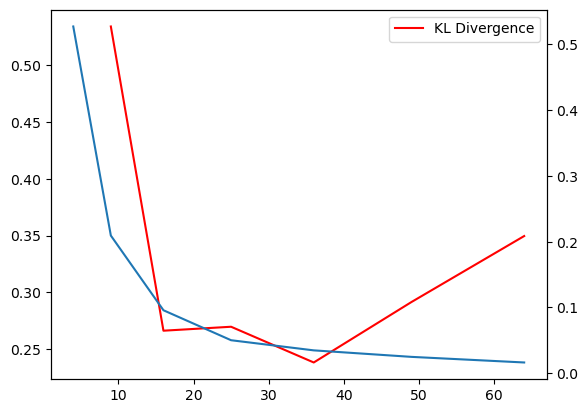

In [7]:
num_grid_points = grid_size_1d**2
fig, ax = plt.subplots(1,1)
ax_t = ax.twinx()
ax.plot(num_grid_points[1:],KL_div, color='red', label='KL Divergence')
ax_t.plot(num_grid_points, rmse_grid, label='Interpolator RMSE (right axis)')
ax.legend()
fig.show()

In [37]:
KL_div

[0.3937928160935814, 0.09893202633840278]

In [9]:
print(len(mc_current.output_samples))
print(10**6)

1000000
1000000


# SparseSpACE

There are many more functions pre-defined in Function.py. It is also possible to compose functions and create combined and scaled functions.

## Standard Combination Technique

So now let's first look at the Truncated Combination Technique with a predefined maximum und minimum level and let's integrate the GenzCornerPeak from before with it. For this purpose we also have to select a grid on which we want to perform the combi. We will use here the equidistant Trapezoidal grid that applies the trapezoidal rule to integrate the function. There are more grids available such as Leja, Clenshaw-Curtis, Gauss-Legendre...

Time used (s):0.0015846589994907845
Number of distinct points used during the refinement (StdCombi): 9
Time used (s):0.0011157669978274498
Number of distinct points used during the refinement (StdCombi): 9
Time used (s):0.0017401820005034097
Number of distinct points used during the refinement (StdCombi): 25
Time used (s):0.0038211679966480006
Number of distinct points used during the refinement (StdCombi): 81
81 81


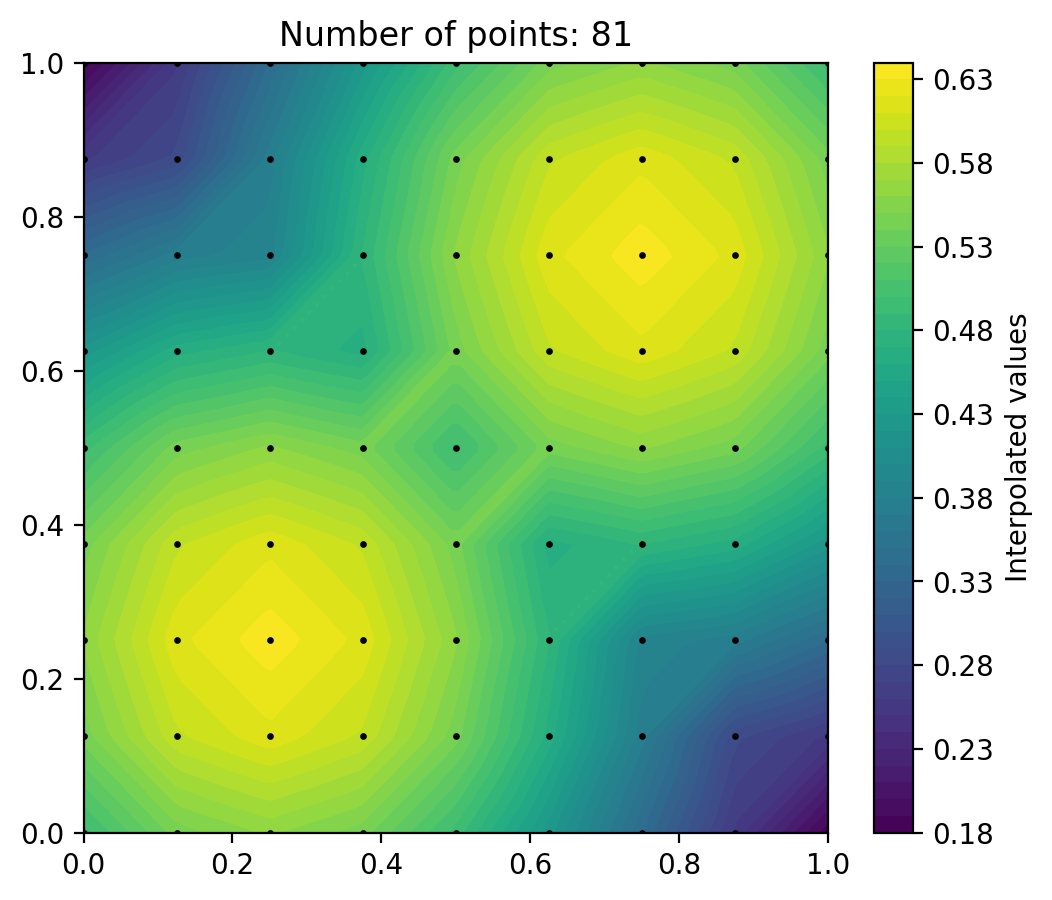

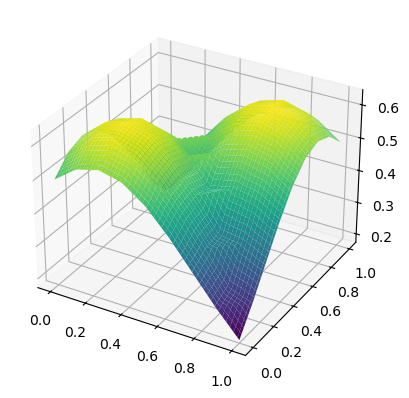

In [10]:
%matplotlib inline
import sparseSpACE
from sparseSpACE.Function import *
from sparseSpACE.StandardCombi import *
from sparseSpACE.Grid import *
import numpy as np
dim = num_dim
a = np.zeros(dim)
b = np.ones(dim)
grid = TrapezoidalGrid(a=a, b=b, boundary=True)
f = mmg_wraped

# NEW! define operation which shall be performed in the combination technique
from sparseSpACE.GridOperation import *
operation = Integration(f=f, grid=grid, dim=dim)#, reference_solution = f.getAnalyticSolutionIntegral(a,b))
combiObject = StandardCombi(a, b, operation=operation)
minimum_level = 1
maximum_level = 1

combiObject.perform_operation(minimum_level, maximum_level)
# print("Combination Scheme:")
# combiObject.print_resulting_combi_scheme(markersize=5)
# print("Sparse Grid:")
# combiObject.print_resulting_sparsegrid(markersize=10)
# print("Plot of combimodel for function:")
# combiObject.plot()

levels = np.arange(3)+1
combi_points = []
combi_npoints_array = []
for l in levels:
    combiObject.perform_operation(l,l)
    combi_points.append(combiObject.get_points())
    combi_npoints_array.append(combiObject.get_total_num_points())

from scipy.interpolate import griddata


points = combi_points[-1]#combiObject.get_points()
p_a = np.array(points)

if num_dim == 2:
    px, py = zip(*points) 
    print(len(px), len(py))
    pf = [f.eval(p) for p in points]

    x = np.linspace(0,1,100)
    y = np.linspace(0,1,100)
    X,Y = np.meshgrid(x,y)
    Z = griddata((px, py), pf, (X, Y), method='linear')

    size=1
    fig = plt.figure(figsize=(6*size,5*size), dpi = 200)
    plt.title(f'Number of points: {combiObject.get_total_num_points()}')
    plt.contourf(X,Y,Z, levels=50, cmap='viridis')
    plt.colorbar(label='Interpolated values')
    plt.scatter(px,py,s=2, c='black')

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')



In [89]:
combiObject.grid

In [11]:
# For true Integral
combiObject.perform_operation(4,4)
StandardCombi_l6_points = combiObject.get_points()
print('Standard COmbi l6, num points:', len(StandardCombi_l6_points))
from sparseSpACE.Integrator import IntegratorArbitraryGrid
integrator = IntegratorArbitraryGrid(combiObject.grid)
true_integral = integrator(mmg_wraped, numPoints=[round(len(StandardCombi_l6_points)**(1/num_dim)) for i in range(num_dim)], start=a, end=b)

Time used (s):0.013749432000622619
Number of distinct points used during the refinement (StdCombi): 289
Standard COmbi l6, num points: 289


In [12]:
print(true_integral)

[0.5074513]


In [13]:
from GENE_ML.gene_ml.models.GPR import GPR
from scipy.integrate import nquad

gpr_overfit = GPR('mmmg', num_dim, 'radial_basis_function', do_overfit=True)
points= StandardCombi_l6_points
        
x_train = np.array(points)
print(x_train.shape) 
z_train = mmg.evaluate(x_train)
print(z_train.shape)

gpr_overfit.fit(x_train, z_train)
print(gpr_overfit.regressor.kern)

mmg_func = lambda x0, x1: mmg.evaluate(np.array([x0,x1]))
integral_true = nquad(mmg_func, ranges=[(0,1),(0,1)])[0]


# x = np.linspace(0,1,test_grid_size)
# y = np.linspace(0,1,test_grid_size)
# X,Y = np.meshgrid(x,y)
# pos_test = np.dstack((X, Y))
# pos_test_flat = np.vstack([X.ravel(), Y.ravel()]).T

# Z_true = mmg.evaluate(pos_test_flat)
# Z_interpolate = gpr_overfit.predict(pos_test_flat, disclude_errors=True)

# print(Z_interpolate)

(289, 2)
(289,)
  rbf.         |               value  |  constraints  |  priors
  variance     |  0.6366197723675814  |      +ve      |        
  lengthscale  |  0.5549514111671742  |      +ve      |        


In [14]:
print(integral_true)

0.5082649496766503


The output shows the combination Scheme that is used which defines the level vectors and the coefficients of the grids. Then the solution of the combination integral is listed followed by the analytic solution and the absolute error. Finally the graphical plot of the combination scheme and the resulting sparse grid is shown.

## Dimension Adaptive Combination Technique

An often used variant of the Standard Combination Technique is the dimension adaptive Combination Technique. An implementation which applies this method is now available within the framework. It is called similarly to the Standard Combination Technique but now we also have to define a tolerance to indicate how long we want to adapt the scheme. The adaptation stops once the relative error of the integration falls below this tolerance threshold.

In [5]:
# #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DOES NOT WORK BECAUSE IT NEEDS AN ANALYTICAL SOLUTION OF THE INTEGRAL. MAYBE TRY ANOTHER OPERATION IF DIMENSIONAL ADAPTIVITY IS DESIRED

# %matplotlib inline
# import sparseSpACE
# from sparseSpACE.Function import *
# from sparseSpACE.DimAdaptiveCombi import *
# from sparseSpACE.Grid import *
# import numpy as np
# dim = 2
# coeffs = [1, 100]
# a = np.zeros(dim)
# b = np.ones(dim)
# grid = TrapezoidalGrid(a=a, b=b)
# f = mmg_wraped#GenzCornerPeak(coeffs=coeffs)
# from sparseSpACE.GridOperation import *
# operation = Integration(f=f, grid=grid, dim=dim)#, reference_solution = f.getAnalyticSolutionIntegral(a,b))
# combiObject = DimAdaptiveCombi(a, b, operation)
# minimum_level = 1
# maximum_level = 2
# combiObject.perform_combi(minimum_level, maximum_level, 10**-2)
# # combiObject.print_resulting_combi_scheme(markersize=5)
# # combiObject.print_resulting_sparsegrid(markersize=10)

# from scipy.interpolate import griddata
# points = combiObject.get_points()
# p_a = np.array(points)


# px, py = zip(*points) 
# print(len(px), len(py))
# pf = [f.eval(p) for p in points]

# x = np.linspace(0,1,100)
# y = np.linspace(0,1,100)
# X,Y = np.meshgrid(x,y)
# Z = griddata((px, py), pf, (X, Y), method='linear')

# size=2
# fig = plt.figure(figsize=(6*size,5*size))
# plt.title(f'Number of points: {len(px)}')
# plt.contourf(X,Y,Z, levels=50, cmap='viridis')
# plt.colorbar(label='Interpolated values')
# plt.scatter(px,py,s=2, c='white')

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, Z, cmap='viridis')


## SpatiallyAdaptiveCombi

Now we come to the core element of this framework: The spatially adaptive Combination Technique. Here several techniques are implemented and can be tested for all test functions. After configuring the grid, the function, and the dimension we need to create the object for the respective strategy (currently we have the $\textit{SpatiallyAdaptiveFixedScheme}$, the $SpatiallyAdaptiveExtendScheme$, the $SpatiallyAdaptiveCellScheme$ and the  $SpatiallyAdaptiveSingleDimensions$). The different Schemes have different configuration parameters one can choose. For further information have a look in the respective class file. The calling conventions for the spatially adaptive combi slightly differe from those of the standard combis and also include and $errorOperator$ which controls the error estimations and we also have the oportunity to plot the sparse grid and the combination scheme after each refinement step by setting $do\_plot$ to $true$. In the following we will demonstrate the refinement for to schemes including the respective plots.

## Cell Scheme

0 [1, 2] 1.0
1 [2, 1] 1.0
2 [1, 1] -1.0
split dimension 0
split dimension 1
Current number of function evaluations 9
combiintegral: 1.369872922211114
Current error: 1.3698729222111141
Finished refinement
Refined 2 times
Current number of function evaluations 17
combiintegral: 1.468895422210949
Current error: 1.4688954222109474
Finished refinement
Refined 2 times
Current number of function evaluations 21
combiintegral: 1.5196522053723103
Current error: 1.5196522053723067
Finished refinement
Refined 8 times
Current number of function evaluations 39
combiintegral: 1.5465317840371144
Current error: 1.5465317840371082
Finished refinement
Refined 8 times
Current number of function evaluations 49
combiintegral: 1.5217413326287812
Current error: 1.5959875360765683
Finished refinement
Refined 8 times
Current number of function evaluations 49
combiintegral: 1.5217413326287812
Current error: 1.5959875360765683
Finished refinement
Refined 16 times
Current number of function evaluations 81
combiint

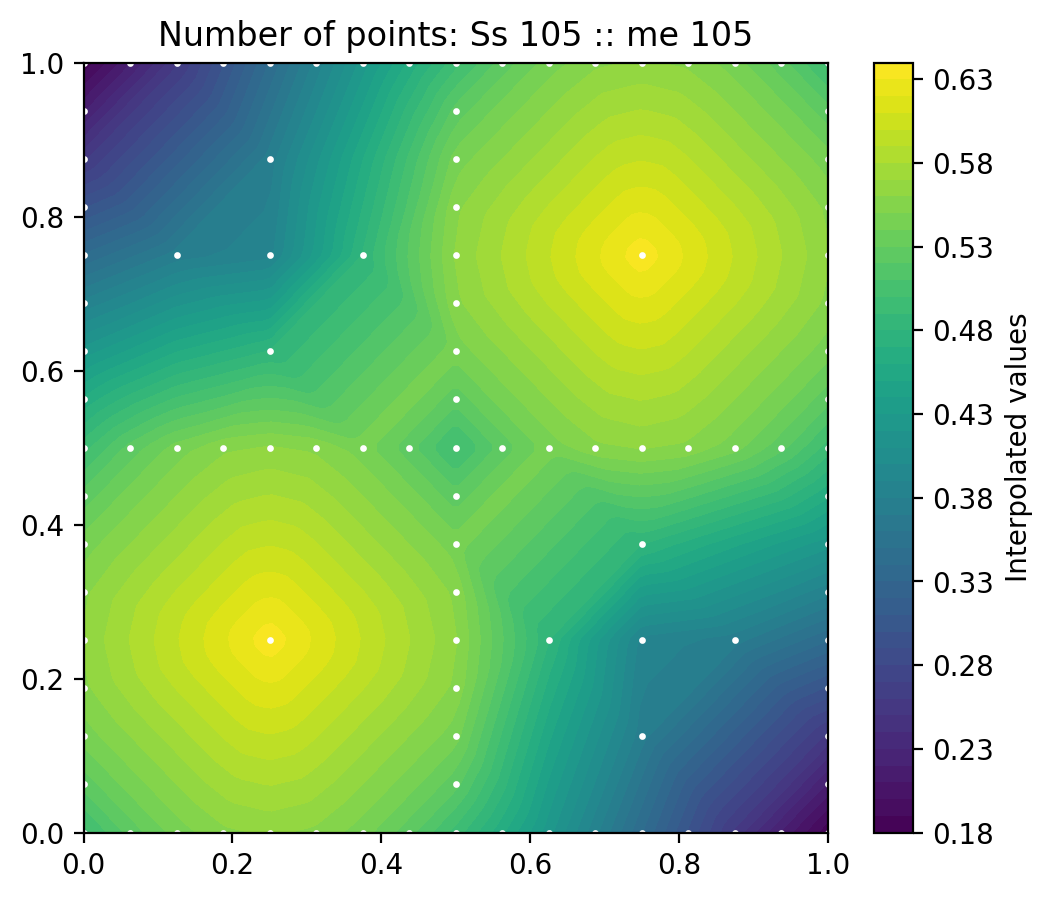

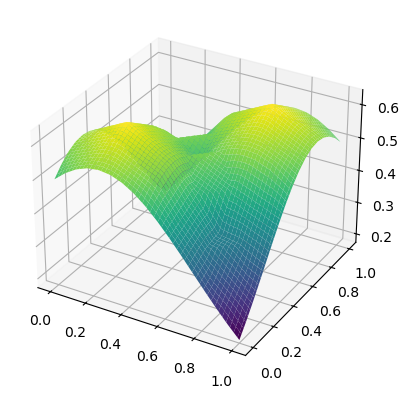

In [15]:
%matplotlib inline
import sparseSpACE
import numpy as np
from sparseSpACE.spatiallyAdaptiveCell import *
from sparseSpACE.Function import *
from sparseSpACE.ErrorCalculator import *

#dimension of the problem
dim = num_dim

# define integration domain boundaries
a = np.zeros(dim)
b = np.ones(dim)

# define function to be integrated
# midpoint = np.ones(dim) * 0.5
# coefficients = np.array([ 10**0 * (d+1) for d in range(dim)])
f = mmg_wraped#GenzDiscontinious(border=midpoint,coeffs=coefficients)
# plot function
# f.plot(np.ones(dim)*a,np.ones(dim)*b)

# reference integral solution for calculating errors
# reference_solution = f.getAnalyticSolutionIntegral(a,b)

# define error estimator for refinement
errorOperator=ErrorCalculatorSurplusCell()

# define equidistant grid
grid=TrapezoidalGrid(a=a, b=b)

# NEW! define operation which shall be performed in the combination technique
from sparseSpACE.GridOperation import *
operation = Integration(f=f, grid=grid, dim=dim)#, reference_solution = reference_solution)

# define Cell refinement strategy for Spatially Adaptive Combination Technique
adaptiveCombiInstanceCell = SpatiallyAdaptiveCellScheme(a, b, operation=operation)

# the cell method does not have component grids and therefore the sparse grid is printed twice per iteration!
# performing the spatially adaptive refinement with the Cell method
adaptiveCombiInstanceCell.performSpatiallyAdaptiv(1, 2, errorOperator, max_evaluations=100, do_plot=False, do_last_plot=False)

print("Number of points used in refinement:", adaptiveCombiInstanceCell.get_total_num_points())


from scipy.interpolate import griddata
cell_points = adaptiveCombiInstanceCell.points_inevery_step#adaptiveCombiInstanceCell.get_points()
cell_npoints_array = adaptiveCombiInstanceCell.num_point_array
points = adaptiveCombiInstanceCell.points_inevery_step[-1]
p_a = np.array(points)

if num_dim == 2:
    px, py = zip(*points) 
    print(len(px), len(py))
    print('debug', np.max(px),np.max(py))
    pf = [f.eval(p) for p in points]

    x = np.linspace(0,1,100)
    y = np.linspace(0,1,100)
    X,Y = np.meshgrid(x,y)
    Z = griddata((px, py), pf, (X, Y), method='linear')

    size=1
    fig = plt.figure(figsize=(6*size,5*size), dpi = 200)
    plt.title(f'Number of points: Ss {adaptiveCombiInstanceCell.get_total_num_points()} :: me {len(points)}')
    plt.contourf(X,Y,Z, levels=50, cmap='viridis')
    plt.colorbar(label='Interpolated values')
    plt.scatter(px,py,s=2, c='white')

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')


In [16]:
integrator = IntegratorArbitraryGrid(adaptiveCombiInstanceCell.grid)
integral = integrator(mmg_wraped, numPoints=[round(len(points)**(1/num_dim)) for i in range(num_dim)], start=a, end=b)

AttributeError: 'TrapezoidalGrid' object has no attribute 'weights'

In [17]:
from sparseSpACE.Integrator import IntegratorArbitraryGrid
for g, p in zip(adaptiveCombiInstanceCell.grid_forevery_step, adaptiveCombiInstanceCell.points_inevery_step):
    integrator = IntegratorArbitraryGrid(g)
    integral = integrator(mmg_wraped, numPoints=[round(len(p)**(1/num_dim)) for i in range(num_dim)], start=a, end=b)
    print(integral)
    

AttributeError: 'TrapezoidalGrid' object has no attribute 'weights'

In [7]:
cell_points[1].shape

(32, 2)

## Extend Scheme

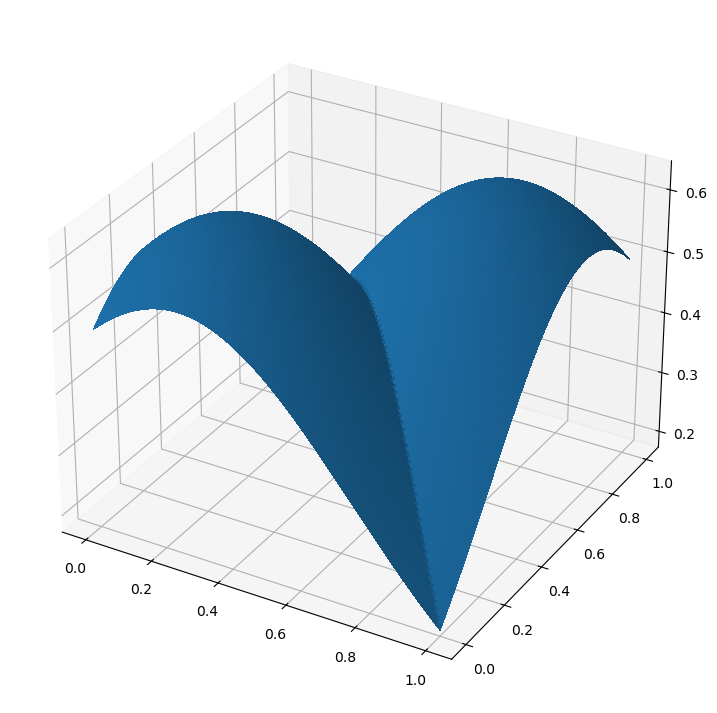

0 [1, 2] 1.0
1 [2, 1] 1.0
2 [1, 1] -1.0
Current number of function evaluations 21
combiintegral: 0.5065507351241021
Current error: 0.016088572279491425
Finished refinement
Refined 2 times
Current number of function evaluations 47
combiintegral: 0.516033943672239
Current error: 0.012152115745137804
Finished refinement
Refined 2 times
Current number of function evaluations 65
combiintegral: 0.5078874393436145
Current error: 0.015015159449238001
Finished refinement
Refined 2 times
Current number of function evaluations 91
combiintegral: 0.5068343654943777
Current error: 0.012936208651079112
Finished refinement
Refined 8 times
Current number of function evaluations 179
combiintegral: 0.5090006088368153
Current error: 0.00548190289648647
Number of refinements: 14
Number of distinct points used during the refinement: 179
Time used adaptive (s): 0.13213430600080756
Final error: 0.00548190289648647
Number of points used in refinement: 179
INITIAL NUMBER OF POINTS: 21 SECOND ITERATION: 47
179 1

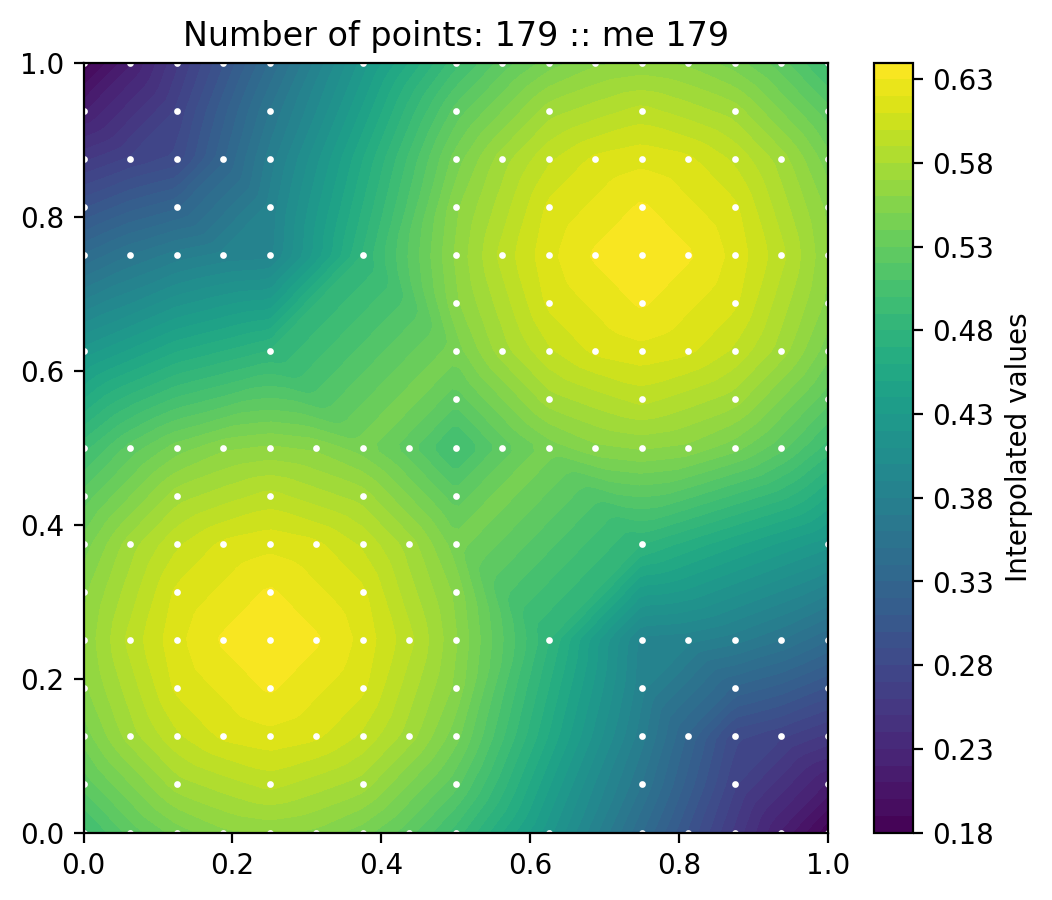

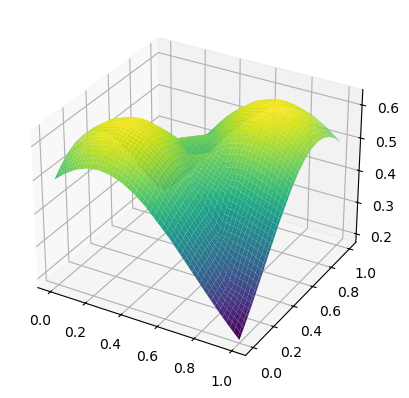

In [18]:
%matplotlib inline
import sparseSpACE
import numpy as np
from sparseSpACE.spatiallyAdaptiveExtendSplit import *
from sparseSpACE.Function import *
from sparseSpACE.ErrorCalculator import *

# dimension of the problem
dim = num_dim

# define integration domain boundaries
a = np.zeros(dim)
b = np.ones(dim)

# define function to be integrated
# midpoint = np.ones(dim) * 0.5
# coefficients = np.array([ 10**0 * (d+1) for d in range(dim)])
f = mmg_wraped#GenzDiscontinious(border=midpoint,coeffs=coefficients)
# plot function
f.plot(np.ones(dim)*a,np.ones(dim)*b)

# reference integral solution for calculating errors
# reference_solution = f.getAnalyticSolutionIntegral(a,b)

# define error estimator for refinement
errorOperator2=ErrorCalculatorExtendSplit()

# define equidistant grid
grid=TrapezoidalGrid(a=a, b=b)

# NEW! define operation which shall be performed in the combination technique
from sparseSpACE.GridOperation import *
operation = Integration(f=f, grid=grid, dim=dim)#, reference_solution = reference_solution)

# define Extend-Split refinement strategy for Spatially Adaptive Combination Technique
adaptiveCombiInstanceExtend = SpatiallyAdaptiveExtendScheme(a, b, 3, version=0, operation=operation)

# performing the spatially adaptive refinement with the Extend-Split method
adaptiveCombiInstanceExtend.performSpatiallyAdaptiv(1, 2, errorOperator2, max_evaluations=100, do_plot=False, do_last_plot=False)

print("Number of points used in refinement:", adaptiveCombiInstanceExtend.get_total_num_points())


from scipy.interpolate import griddata
extend_points = adaptiveCombiInstanceExtend.points_inevery_step
extend_npoints_array = adaptiveCombiInstanceExtend.num_point_array
points = adaptiveCombiInstanceExtend.points_inevery_step[-1]#adaptiveCombiInstanceCell.get_points()
initial_points = adaptiveCombiInstanceExtend.points_inevery_step[0]
print('INITIAL NUMBER OF POINTS:', len(initial_points), 'SECOND ITERATION:', len(adaptiveCombiInstanceExtend.points_inevery_step[1]))
if num_dim == 2:
    p_a = np.array(points)
    px, py = zip(*points) 
    print(len(px), len(py))
    pf = [f.eval(p) for p in points]

    x = np.linspace(0,1,100)
    y = np.linspace(0,1,100)
    X,Y = np.meshgrid(x,y)
    Z = griddata((px, py), pf, (X, Y), method='linear')

    size=1
    fig = plt.figure(figsize=(6*size,5*size), dpi=200)
    plt.title(f'Number of points: {adaptiveCombiInstanceExtend.get_total_num_points(distinct_function_evals=True)} :: me {len(points)}')
    plt.contourf(X,Y,Z, levels=50, cmap='viridis')
    plt.colorbar(label='Interpolated values')
    plt.scatter(px,py,s=2, c='white')

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')

## Single Dim Scheme

NUM DIM 2


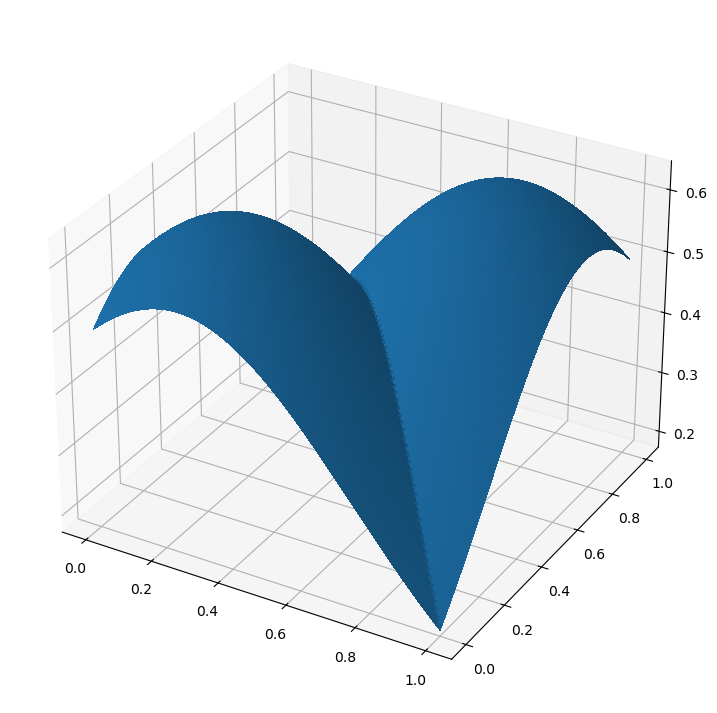

0 [1, 2] 1.0
1 [2, 1] 1.0
2 [1, 1] -1.0
Current number of function evaluations 21
combiintegral: 0.506550735124102
Current error: 0.049926427720397404
Finished refinement
Refined 8 times
Current number of function evaluations 49
combiintegral: 0.5072471108762575
Current error: 0.018075314861373523
Finished refinement
Refined 16 times
Current number of function evaluations 113
combiintegral: 0.5108519471130879
Current error: 0.0012637932603584132
Number of refinements: 24
Number of distinct points used during the refinement: 113
Time used adaptive (s): 0.0362945810011297
Final error: 0.0012637932603584132
Number of points used in refinement: 113
INITIAL NUMBER OF POINTS: 21 SECOND ITERATION: 49
unique (113, 2) (113, 2)
113 113
GPR is a parameterless approach and does not have a training step. Instead the hyperparameters are tuned to the data.
OPTIMISING THE HYPERPERS
CURRENT HYPERS:
 
Name : GP regression
Objective : 466297.4095402588
Number of Parameters : 3
Number of Optimization Para

 /home/djdaniel/anaconda3/envs/gene_ml/lib/python3.12/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 4/10, f = -131.98385734623298
Optimization restart 5/10, f = -131.9838573466286
Optimization restart 6/10, f = -131.98385734664367
Optimization restart 7/10, f = -131.98385734640044
Optimization restart 8/10, f = -131.98385734665038
Optimization restart 9/10, f = -131.98385734662992
Optimization restart 10/10, f = -131.98385734648264
RESULTING HYPERS:
 
Name : GP regression
Objective : -131.98385734665038
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   0.0718686764283458  |      +ve      |        
  rbf.lengthscale          |  0.10604575140572141  |      +ve      |        
  Gaussian_noise.variance  |                  0.0  |   +ve fixed   |        
KERNEL COMP
  rbf.         |                value  |  constraints  |  priors
  variance     |   0.0718686764283458  |      +ve      |        
  lengthscale  |  0.1060457514

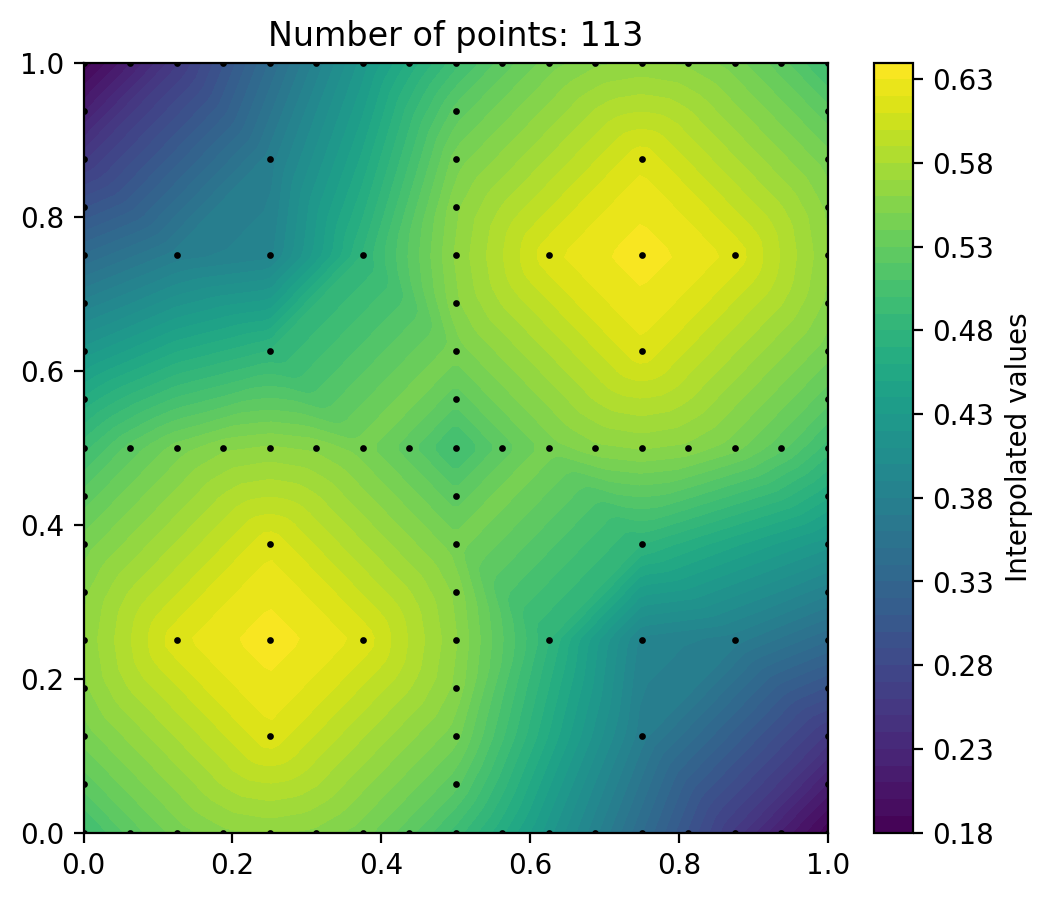

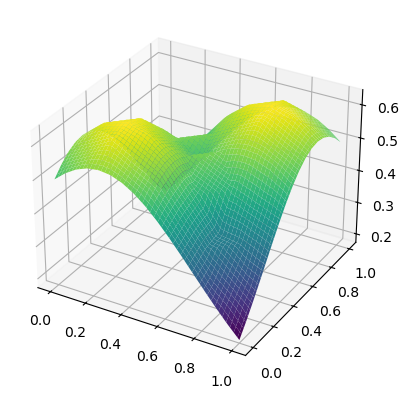

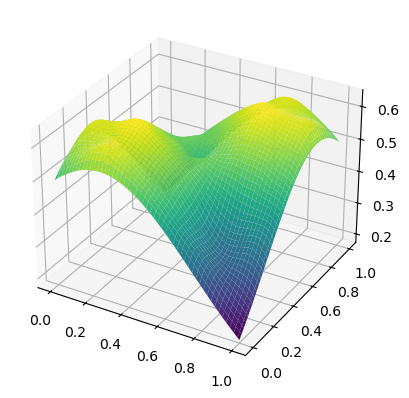

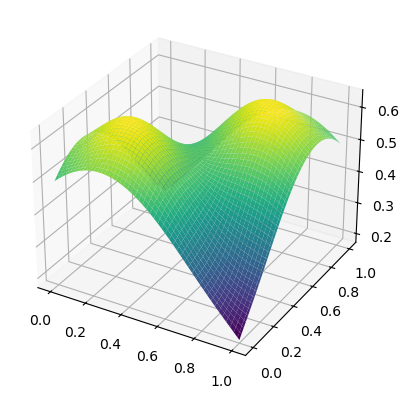

In [19]:
%matplotlib inline
import sparseSpACE
import numpy as np
from sparseSpACE.spatiallyAdaptiveSingleDimension2 import *
from sparseSpACE.Function import *
from sparseSpACE.ErrorCalculator import *

# dimension of the problem
dim = num_dim
print('NUM DIM', dim)

# define integration domain boundaries
a = np.zeros(dim)
b = np.ones(dim)

# define function to be integrated
# midpoint = np.ones(dim) * 0.5
# coefficients = np.array([ 10**0 * (d+1) for d in range(dim)])
f = mmg_wraped#GenzDiscontinious(border=midpoint,coeffs=coefficients)
# plot function
f.plot(np.ones(dim)*a,np.ones(dim)*b)

# reference integral solution for calculating errors
# reference_solution = f.getAnalyticSolutionIntegral(a,b)

# define error estimator for refinement
errorOperator = ErrorCalculatorSingleDimVolumeGuided()

# define equidistant grid
grid=GlobalTrapezoidalGrid(a=a, b=b, modified_basis=False, boundary=True)

# NEW! define operation which shall be performed in the combination technique
from sparseSpACE.GridOperation import *
operation = Integration(f=f, grid=grid, dim=dim)#, reference_solution=reference_solution)

# define SingleDim refinement strategy for Spatially Adaptive Combination Technique
adaptiveCombiInstanceSingleDim = SpatiallyAdaptiveSingleDimensions2(np.ones(dim) * a, np.ones(dim) * b, operation=operation)

# performing the spatially adaptive refinement with the SingleDim method
adaptiveCombiInstanceSingleDim.performSpatiallyAdaptiv(1, 2, errorOperator, 10**-2, max_evaluations=100, do_plot=False, do_last_plot=False)

print("Number of points used in refinement:", adaptiveCombiInstanceSingleDim.get_total_num_points())

from scipy.interpolate import griddata
from GENE_ML.gene_ml.models.GPR import GPR

gpr_overfit = GPR('mmmg', num_dim, 'radial_basis_function', do_overfit=False)
gpr_overfit2 = GPR('mmmg', num_dim, 'radial_basis_function', do_overfit=True)


sdim_points = adaptiveCombiInstanceSingleDim.points_inevery_step 
sdim_npoints_array = adaptiveCombiInstanceSingleDim.num_point_array
points = adaptiveCombiInstanceSingleDim.points_inevery_step[-1]#adaptiveCombiInstanceCell.get_points()
initial_points = adaptiveCombiInstanceSingleDim.points_inevery_step[0]
print('INITIAL NUMBER OF POINTS:', len(initial_points), 'SECOND ITERATION:', len(adaptiveCombiInstanceSingleDim.points_inevery_step[1]))

if num_dim==2:
    p_a = np.array(points)

    pp = np.unique(p_a, axis=0)
    print('unique', p_a.shape, pp.shape)


    px, py = zip(*points) 
    print(len(px), len(py))
    pf = [f.eval(p) for p in points]
    gpr_overfit.fit(points, pf)
    gpr_overfit2.fit(points, pf)

    print('KERNEL COMP')
    print(gpr_overfit.regressor.kern)
    print(gpr_overfit2.regressor.kern)

    x = np.linspace(0,1,100)
    y = np.linspace(0,1,100)
    X,Y = np.meshgrid(x,y)
    pos_test_flat = np.vstack([X.ravel(), Y.ravel()]).T
    Z = griddata((px, py), pf, (X, Y), method='linear')

    Z_gpr = gpr_overfit.predict(pos_test_flat, disclude_errors=True)
    Z_gpr = Z_gpr.reshape(Z.shape)

    Z_gpr2 = gpr_overfit2.predict(pos_test_flat, disclude_errors=True)
    Z_gpr2 = Z_gpr2.reshape(Z.shape)


    size=1
    fig = plt.figure(figsize=(6*size,5*size), dpi=200)
    plt.title(f'Number of points: {len(px)}')
    plt.contourf(X,Y,Z, levels=50, cmap='viridis')
    plt.colorbar(label='Interpolated values')
    plt.scatter(px,py,s=2, c='black')

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z_gpr, cmap='viridis')

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z_gpr2, cmap='viridis')

In [104]:
integrator = IntegratorArbitraryGrid(adaptiveCombiInstanceExtend.grid_forevery_step[-2])
print('np:',adaptiveCombiInstanceExtend.grid.get_num_points())
integral = integrator(mmg_wraped, numPoints=[2 for i in range(num_dim)], start=a, end=b)
print(integral)

np: 8
[0.00882062]


In [ ]:
# from GENE_ML.gene_ml.models.GPR import GPR

# gpr_overfit = GPR('mmmg', num_dim, 'radial_basis_function', do_overfit=True)

        
# x_train = np.array(points)
# print(x_train.shape) 
# z_train = mmg.evaluate(x_train)
# print(z_train.shape)

# gpr_overfit.fit(x_train, z_train)
# print(gpr_overfit.regressor.kern)

# x = np.linspace(0,1,test_grid_size)
# y = np.linspace(0,1,test_grid_size)
# X,Y = np.meshgrid(x,y)
# pos_test = np.dstack((X, Y))
# pos_test_flat = np.vstack([X.ravel(), Y.ravel()]).T

# Z_true = mmg.evaluate(pos_test_flat)
# Z_interpolate = gpr_overfit.predict(pos_test_flat, disclude_errors=True)

# print(Z_interpolate)

(78, 2)
(78,)
  rbf.         |               value  |  constraints  |  priors
  variance     |  0.8267720700379726  |      +ve      |        
  lengthscale  |  0.6296273524465392  |      +ve      |        


NameError: name 'test_grid_size' is not defined

In [ ]:
# from GENE_ML.gene_ml.models.GPR import GPR

# gpr_overfit = GPR('mmmg', num_dim, 'radial_basis_function', do_overfit=True)

        
# x_train = np.array(points)
# print(x_train.shape) 
# z_train = mmg.evaluate(x_train)
# print(z_train.shape)

# gpr_overfit.fit(x_train, z_train)
# print(gpr_overfit.regressor.kern)

# x = np.linspace(0,1,test_grid_size)
# y = np.linspace(0,1,test_grid_size)
# X,Y = np.meshgrid(x,y)
# pos_test = np.dstack((X, Y))
# pos_test_flat = np.vstack([X.ravel(), Y.ravel()]).T

# Z_true = mmg.evaluate(pos_test_flat)
# Z_interpolate = gpr_overfit.predict(pos_test_flat, disclude_errors=True)

# print(Z_interpolate)

(81, 2)
(81,)
  rbf.         |               value  |  constraints  |  priors
  variance     |  0.8431913475543124  |      +ve      |        
  lengthscale  |  0.5900518759499289  |      +ve      |        
[0.1609791  0.16524352 0.16959259 ... 0.69974529 0.69225936 0.6845813 ]


(120, 3)
(120,)
  rbf.         |               value  |  constraints  |  priors
  variance     |  0.7643522189258889  |      +ve      |        
  lengthscale  |  0.8619996315696817  |      +ve      |        


NameError: name 'test_grid_size' is not defined

##  Comparison: RMSE, Integral Accuracy, Sobel Index Accuracy, 2D

debug shape (10000,) (10000, 2)
debug true 0.5082649496766503


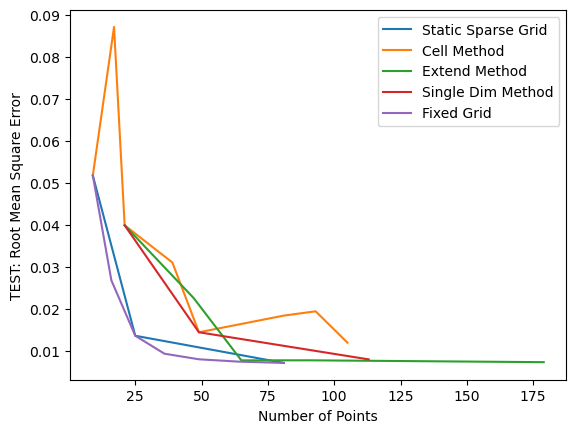

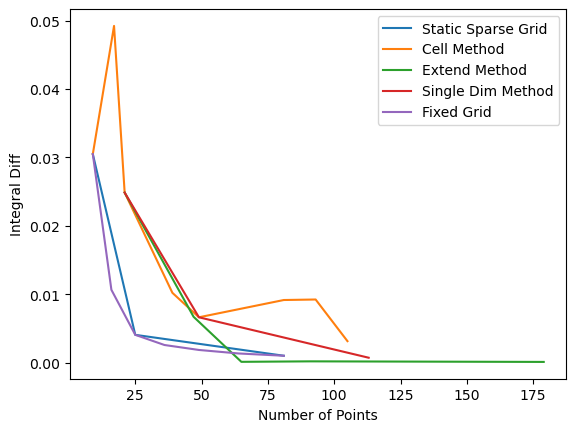

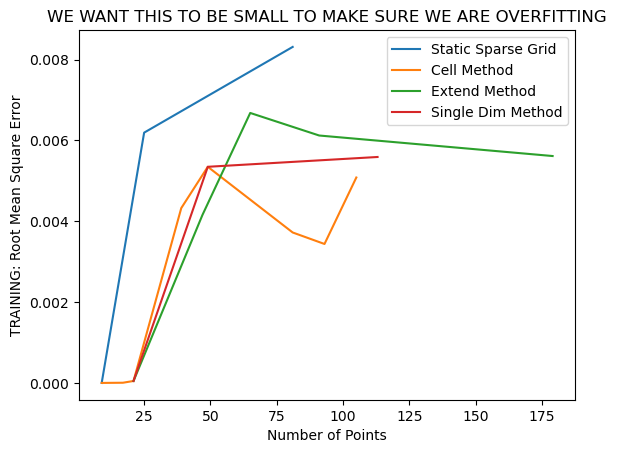

In [20]:
from scipy.interpolate import griddata
from GENE_ML.gene_ml.models.GPR import GPR
from scipy.integrate import nquad

gpr_overfit = GPR('mmmg', num_dim, 'radial_basis_function', do_overfit=True)

points_by_method = [combi_points, cell_points, extend_points, sdim_points]
num_points_by_method = [combi_npoints_array, cell_npoints_array, extend_npoints_array, sdim_npoints_array]
method_names = ['Static Sparse Grid', 'Cell Method', 'Extend Method', 'Single Dim Method']
rmse_by_method = []
train_error_by_method = []
integral_diff_by_method = []
test_grid_size = 100
x = np.linspace(0,1,test_grid_size)
y = np.linspace(0,1,test_grid_size)
X,Y = np.meshgrid(x,y)
pos_test = np.dstack((X, Y))
pos_test_flat = np.vstack([X.ravel(), Y.ravel()]).T
Z_true = mmg.evaluate(pos_test_flat)
print('debug shape', Z_true.shape, pos_test_flat.shape)
mmg_func = lambda x0, x1: mmg.evaluate(np.array([x0,x1]))
integral_true = nquad(mmg_func, ranges=[(0,1),(0,1)])[0]
print('debug true', integral_true)

for points, method_name in zip(points_by_method, method_names):
    # print('DEBUG_', method_name, points.shape)
    rmse = []
    train_error = []
    integral_diff = []
    for p_step in points:
        px, py = zip(*p_step) 
        # print('DEBUG_', method_name, p_step.shape)
        z_train = [mmg_wraped.eval(p) for p in p_step]
        
        gpr_overfit.fit(np.array(p_step), np.array(z_train))
        Z_interpolate = gpr_overfit.predict(pos_test_flat, disclude_errors=True)#griddata((px, py), z_train, (X, Y), method='linear')
        rmse.append(np.sqrt(np.mean((Z_true - Z_interpolate)**2)))
        gpr_overfit_func = lambda x0, x1: gpr_overfit.predict(np.array([[x0,x1]]), disclude_errors=True)
        integral_interpolate = nquad(gpr_overfit_func, ranges=[(0,1),(0,1)])[0]
        integral_diff.append(np.abs(integral_interpolate - integral_true))
        z_train = np.array(z_train)
        z_train_check = gpr_overfit.predict(p_step, disclude_errors=True)#[gpr_overfit.predict(p, disclude_errors=True) for p in p_step]
        train_error.append(np.sqrt(np.mean((z_train - z_train_check)**2)))
    rmse_by_method.append(rmse)
    train_error_by_method.append(train_error)
    integral_diff_by_method.append(integral_diff)
    
# equidistant fixed grid
num_grid_points = np.arange(3,10)
rmse_grid = []
integral_diff_grid = []
num_points_grid = []
for ng in num_grid_points:
    x = np.linspace(0,1,ng)
    y = np.linspace(0,1,ng)

    p_step, px, py, z_train = [], [], [], []
    for xi in x:
        for yi in y:
            px.append(xi)
            py.append(yi)
            z_train.append(mmg_wraped.eval((xi,yi)))
            p_step.append([xi,yi])
    
    
    # Z_interpolate = griddata((px,py), z_train, (X, Y), method='linear')
    gpr_overfit.fit(np.array(p_step), np.array(z_train))
    Z_interpolate = gpr_overfit.predict(pos_test_flat, disclude_errors=True)#griddata((px, py), z_train, (X, Y), method='linear')
    gpr_overfit_func = lambda x0, x1: gpr_overfit.predict(np.array([[x0,x1]]), disclude_errors=True)
    integral_interpolate = nquad(gpr_overfit_func, ranges=[(0,1),(0,1)])[0]
    integral_diff_grid.append(np.abs(integral_interpolate - integral_true))
        
    # Z_true = mmg.evaluate(pos_test)
    rmse_grid.append(np.sqrt(np.mean((Z_true - Z_interpolate)**2)))
    num_points_grid.append(ng**2)
        

fig = plt.figure()
for rmse, num_points, method_name in zip(rmse_by_method, num_points_by_method, method_names):
    plt.plot(num_points, rmse, label=method_name)
    
plt.plot(num_points_grid, rmse_grid, label='Fixed Grid')
plt.ylabel('TEST: Root Mean Square Error')
plt.xlabel('Number of Points')
plt.legend()
plt.show()

fig = plt.figure()
for integral_diff, num_points, method_name in zip(integral_diff_by_method, num_points_by_method, method_names):
    plt.plot(num_points, integral_diff, label=method_name)
plt.plot(num_points_grid, integral_diff_grid, label='Fixed Grid')
plt.ylabel('Integral Diff')
plt.xlabel('Number of Points')
plt.legend()
plt.show()

fig = plt.figure()
for train_er, num_points, method_name in zip(train_error_by_method, num_points_by_method, method_names):
    plt.plot(num_points, train_er, label=method_name)
    
# plt.plot(num_points_grid, rmse_grid, label='Fixed Grid')
plt.ylabel('TRAINING: Root Mean Square Error')
plt.title('WE WANT THIS TO BE SMALL TO MAKE SURE WE ARE OVERFITTING')
plt.xlabel('Number of Points')
plt.legend()
plt.show()

# Comparison 3D+

In [107]:
import sys
import os
sys.path.append(os.path.join(os.curdir,'..'))
from scipy.interpolate import griddata
from GENE_ML.gene_ml.models.GPR import GPR
from scipy.integrate import nquad
import numpy as np
num_dim=3


points_by_method = [combi_points, cell_points, extend_points, sdim_points]
num_points_by_method = [combi_npoints_array, cell_npoints_array, extend_npoints_array, sdim_npoints_array]
method_names = ['Static Sparse Grid', 'Cell Method', 'Extend Method', 'Single Dim Method']
rmse_by_method = []
train_error_by_method = []
integral_diff_by_method = []
test_grid_size = 100

from GENE_ML.gene_ml.models.GPR import GPR
gpr = GPR('mmmg', num_dim, 'radial_basis_function', do_overfit=False)        

# x = np.repeat([np.linspace(0,1,test_grid_size)], num_dim)
# X = np.meshgrid(*x)
# pos_test = np.dstack(X)
# pos_test_flat = np.vstack([Xi.ravel() for Xi in X]).T

# Z_true = mmg.evaluate(pos_test_flat)
# gpr.fit(pos_test_flat, Z_true)
# print(gpr.regressor.kern)

# Z_interpolate = gpr_overfit.predict(pos_test_flat, disclude_errors=True)
# mmg_func = lambda x0, x1, x3: gpr.predict(np.array([x0,x1, x3]))
# ranges= [[0,1] for i in range(num_dim)]
# print('RANGES',ranges)
# integral_true = nquad(mmg_func, ranges=ranges)
# x = np.linspace(0,1,test_grid_size)
# y = np.linspace(0,1,test_grid_size)
# X,Y = np.meshgrid(x,y)
# pos_test = np.dstack((X, Y))
# pos_test_flat = np.vstack([X.ravel(), Y.ravel()]).T
# Z_true = mmg.evaluate(pos_test_flat)
# print('debug shape', Z_true.shape, pos_test_flat.shape)
# mmg_func = lambda x0, x1: mmg.evaluate(np.array([x0,x1]))
# integral_true = nquad(mmg_func, ranges=[(0,1),(0,1)])[0]
# print('debug true', integral_true)

for points, method_name in zip(points_by_method, method_names):
    # print('DEBUG_', method_name, points.shape)
    rmse = []
    train_error = []
    integral_diff = []
    for p_step in points:
        px, py, pz = zip(*p_step) 
        # print('DEBUG_', method_name, p_step.shape)
        z_train = [mmg_wraped.eval(p) for p in p_step]
        
        gpr.fit(np.array(p_step), np.array(z_train))
        Z_interpolate = gpr.predict(pos_test_flat, disclude_errors=True)#griddata((px, py), z_train, (X, Y), method='linear')
        # rmse.append(np.sqrt(np.mean((Z_true - Z_interpolate)**2)))
        gpr_overfit_func = lambda x0, x1, x2: gpr.predict(np.array([[x0,x1,x2]]), disclude_errors=True)
        integral_interpolate = nquad(gpr_overfit_func, ranges=[(0,1),(0,1),(0,1)])[0]
        integral_diff.append(np.abs(integral_interpolate - integral_true))
        z_train = np.array(z_train)
        z_train_check = gpr.predict(p_step, disclude_errors=True)#[gpr_overfit.predict(p, disclude_errors=True) for p in p_step]
        train_error.append(np.sqrt(np.mean((z_train - z_train_check)**2)))
    rmse_by_method.append(rmse)
    train_error_by_method.append(train_error)
    integral_diff_by_method.append(integral_diff)
    
# # equidistant fixed grid
# num_grid_points = np.arange(3,10)
# rmse_grid = []
# integral_diff_grid = []
# num_points_grid = []
# for ng in num_grid_points:
#     x = np.linspace(0,1,ng)
#     y = np.linspace(0,1,ng)

#     p_step, px, py, z_train = [], [], [], []
#     for xi in x:
#         for yi in y:
#             px.append(xi)
#             py.append(yi)
#             z_train.append(mmg_wraped.eval((xi,yi)))
#             p_step.append([xi,yi])
    
    
    # Z_interpolate = griddata((px,py), z_train, (X, Y), method='linear')
    gpr_overfit.fit(np.array(p_step), np.array(z_train))
    Z_interpolate = gpr_overfit.predict(pos_test_flat, disclude_errors=True)#griddata((px, py), z_train, (X, Y), method='linear')
    gpr_overfit_func = lambda x0, x1: gpr_overfit.predict(np.array([[x0,x1]]), disclude_errors=True)
    integral_interpolate = nquad(gpr_overfit_func, ranges=[(0,1),(0,1)])[0]
    integral_diff_grid.append(np.abs(integral_interpolate - integral_true))
        
    # Z_true = mmg.evaluate(pos_test)
    rmse_grid.append(np.sqrt(np.mean((Z_true - Z_interpolate)**2)))
    num_points_grid.append(ng**2)
        

# fig = plt.figure()
# for rmse, num_points, method_name in zip(rmse_by_method, num_points_by_method, method_names):
#     plt.plot(num_points, rmse, label=method_name)
    
# # plt.plot(num_points_grid, rmse_grid, label='Fixed Grid')
# plt.ylabel('TEST: Root Mean Square Error')
# plt.xlabel('Number of Points')
# plt.legend()
# plt.show()

fig = plt.figure()
for integral_diff, num_points, method_name in zip(integral_diff_by_method, num_points_by_method, method_names):
    plt.plot(num_points, integral_diff, label=method_name)
# plt.plot(num_points, integral_diff_grid, label='Fixed Grid')
plt.ylabel('Integral Diff')
plt.xlabel('Number of Points')
plt.legend()
plt.show()

fig = plt.figure()
for train_er, num_points, method_name in zip(train_error_by_method, num_points_by_method, method_names):
    plt.plot(num_points, train_er, label=method_name)
    
# plt.plot(num_points_grid, rmse_grid, label='Fixed Grid')
plt.ylabel('TRAINING: Root Mean Square Error')
plt.title('WE WANT THIS TO BE SMALL TO MAKE SURE WE ARE OVERFITTING')
plt.xlabel('Number of Points')
plt.legend()
plt.show()

GPR is a parameterless approach and does not have a training step. Instead the hyperparameters are tuned to the data.
OPTIMISING THE HYPERPERS
CURRENT HYPERS:
 
Name : GP regression
Objective : 124.97410191527825
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    0.0  |      +ve      |        
OPTIMISING THE HYPERPERS:
Optimization restart 1/10, f = -22.791530219080542
Optimization restart 2/10, f = -22.791530219080794
Optimization restart 3/10, f = -22.791530219080784
Optimization restart 4/10, f = -22.79153021908068
Optimization restart 5/10, f = -22.79153021908018
Optimization restart 6/10, f = -22.79153021907748
Optimization restart 7/10, f = -22.79153021908054


 /home/djdaniel/anaconda3/envs/gene_ml/lib/python3.12/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 8/10, f = -22.79153021904073
Optimization restart 9/10, f = -22.791530219055605
Optimization restart 10/10, f = -22.791530219080663
RESULTING HYPERS:
 
Name : GP regression
Objective : -22.791530219080794
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |  0.03643371595268569  |      +ve      |        
  rbf.lengthscale          |   0.5253106307731843  |      +ve      |        
  Gaussian_noise.variance  |                  0.0  |   +ve fixed   |        


 /home/djdaniel/anaconda3/envs/gene_ml/lib/python3.12/site-packages/GPy/inference/latent_function_inference/posterior.py:178: SyntaxWarning:invalid escape sequence '\S'
 /home/djdaniel/anaconda3/envs/gene_ml/lib/python3.12/site-packages/GPy/inference/latent_function_inference/posterior.py:200: SyntaxWarning:invalid escape sequence '\S'
 /home/djdaniel/anaconda3/envs/gene_ml/lib/python3.12/site-packages/GPy/kern/src/kern.py:147: SyntaxWarning:invalid escape sequence '\p'
 /home/djdaniel/anaconda3/envs/gene_ml/lib/python3.12/site-packages/GPy/kern/src/kern.py:153: SyntaxWarning:invalid escape sequence '\p'
 /home/djdaniel/anaconda3/envs/gene_ml/lib/python3.12/site-packages/GPy/kern/src/kern.py:159: SyntaxWarning:invalid escape sequence '\p'
 /home/djdaniel/anaconda3/envs/gene_ml/lib/python3.12/site-packages/GPy/kern/src/kern.py:165: SyntaxWarning:invalid escape sequence '\p'
 /home/djdaniel/anaconda3/envs/gene_ml/lib/python3.12/site-packages/GPy/kern/src/kern.py:173: SyntaxWarning:invali

IndexError: index 2 is out of bounds for axis 1 with size 2

In [11]:
print(rmse_by_method)
print(method_names)

NameError: name 'rmse_by_method' is not defined

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

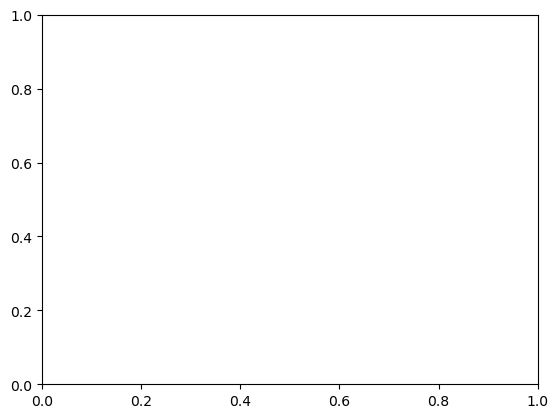

In [12]:
from scipy.interpolate import griddata

points_by_method = [combi_points, cell_points, extend_points, sdim_points]
method_names = ['Static Sparse Grid', 'Cell Method', 'Extend Method', 'Single Dim Method']
rmse_by_method = []
num_points_by_method = []
test_grid_size = 100
x = np.linspace(0,1,test_grid_size)
y = np.linspace(0,1,test_grid_size)
X,Y = np.meshgrid(x,y)
pos_test = np.dstack((X, Y))
        
for points in points_by_method:
    rmse = []
    num_points = []
    for p_step in points:
        px, py = zip(*p_step) 
        z_train = [mmg_wraped.eval(p) for p in p_step]
        Z_interpolate = griddata((px, py), z_train, (X, Y), method='linear')
        Z_true = mmg.evaluate(pos_test)
        rmse.append(np.sqrt(np.mean((Z_true - Z_interpolate)**2)))
        num_points.append(np.unique(p_step))

    rmse_by_method.append(rmse)
    num_points_by_method.append(num_points)

# equidistant fixed grid
num_grid_points = np.arange(3,17)
rmse_grid = []
num_points_grid = []
for ng in num_grid_points:
    x = np.linspace(0,1,ng)
    y = np.linspace(0,1,ng)

    px, py, z_train = [], [], []
    for xi in x:
        for yi in y:
            px.append(xi)
            py.append(yi)
            z_train.append(mmg_wraped.eval((xi,yi)))
    
    Z_interpolate = griddata((px,py), z_train, (X, Y), method='linear')
    Z_true = mmg.evaluate(pos_test)
    rmse_grid.append(np.sqrt(np.mean((Z_true - Z_interpolate)**2)))
    num_points_grid.append(ng**2)
        

fig = plt.figure()
for rmse, num_points, method_name in zip(rmse_by_method, num_points_by_method, method_names):
    plt.plot(num_points, rmse, label=method_name)

# plt.plot(num_points_grid, rmse_grid, label='Fixed Grid')

plt.ylabel('Root Mean Square Error')
plt.xlabel('Number of Points')
plt.legend()
plt.show()